# Scanning CVEs for git-based commit URLs

In [729]:
import urllib.request
from unidiff import PatchSet
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import json
from pandas import json_normalize
from tabulate import tabulate 
import glob
# time of execution
import time
from pathlib import Path

DIR = 'data/cvelistV5-main/cves/'
output_dir = 'data/FixMe/'

Path('figure').mkdir(parents=True, exist_ok=True)
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [730]:
# import sqlite3
import sqlite3
from sqlite3 import Error

# Connect to SQLite database
conn = sqlite3.connect(output_dir + 'Fixme.db')
cur = conn.cursor()


In [731]:

def find_json_files(directory):
    """Find all JSON files in the given directory (including subdirectories).
    """
    json_files = glob.glob(os.path.join(directory, '**/*.json'), recursive=True)
    return json_files

def find_commit_urls(urls):
    """collect all the URLs of they are commit hashes
    """
    commit_urls = [url for url in urls if 'commit' in url]
    return commit_urls

def find_urls(json_files):
    """collect all the URLs from the CVE Json files
    """
    patch_links = {}

    if json_files:
        # print(f"JSON files found: {len(json_files)}")
        for json_file in json_files:
            if os.path.isfile(json_file):
                try:
                    # with open(json_file, 'r') as f:
                    df = pd.read_json(json_file)
                    refs = df.containers.cna['references']
                    urls = [ref['url'] for ref in refs if 'url' in ref]
                    commit_urls = find_commit_urls(urls)

                    if commit_urls:
                        patch_links[json_file] = commit_urls
                    
                except Exception as exec:
                    print(f'Error reading JSON file {json_file}: {exec}')

    else:
        print("No JSON file found in the directory.")
    return patch_links 

if not os.path.isdir(DIR):
    print("Invalid directory path.")
    exit(2)

json_files = find_json_files(DIR)
patch_links = find_urls(json_files)
print(f'Number of URL links: {len(patch_links)}')
# [x  for x in urls if 'github' in x]

Error reading JSON file data/cvelistV5-main/cves/deltaLog.json: 'DataFrame' object has no attribute 'containers'
Error reading JSON file data/cvelistV5-main/cves/delta.json: All arrays must be of the same length
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2170.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2799.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2644.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2795.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2517.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2215.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2235.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/2013/2xxx/CVE-2013-2971.json: 'references'
Error reading JSON file data/cvelistV5-main/cves/201

In [ ]:
def map_rename(columns):
    """Create a renaming mapping dictionary
    """
    rename_mapping = {}
    for key in columns:
        rename_mapping[key] = (key.split('.')[-1])
    return rename_mapping


# json_file = 'cvelistV5-main/cves/2024/21xxx/CVE-2024-21309.json'

def json2df(json_file):
    """Convert JSON data to a pandas DataFrame
    """
    # Read JSON data from file
    with open(json_file, 'r') as f:
        json_data = json.load(f)
        
    df = json_normalize(json_data, max_level=5)
    df = df.rename(columns=map_rename(df.columns))
    return df

# function to merge all json files into a single dataframe
def merge_json_files(json_files):
    """Merge all the JSON files into a single DataFrame
    """
    # totoal number of json files
    print('='*20 + 'Merging JSON files' + '='*20)
    print(f'#JSON files to scan: {len(json_files)}')
    print('='*40)
    df = pd.DataFrame()
    for json_file in json_files:
        try:
            df_json = json2df(json_file)
            # dfs = [json2df(json_file) for json_file in json_files]
            # print(f'Number of DataFrames: {len(dfs)}')
            # try:
            if 'cveId' in list(df_json.columns):
                if df.empty:
                    df = df_json
                else:
                    unique_cols = list(set(list(df.columns) + list(df_json.columns)))
                    # insert new columns with None values
                    for column in unique_cols:
                        if column not in list(df.columns):
                            df[column] = None
                        if column not in list(df_json.columns):
                            df_json[column] = None

                    df= df.sort_index(axis=1)
                    df_json= df_json.sort_index(axis=1)

                    df = pd.concat([df, df_json], ignore_index=True, sort=False)
                # print('='*20)
            # verbose how many files have been processed
            if len(df) % 500 == 0:
                print(f'#files scanned: {len(df)}')
                print('='*40)
        

        except Exception as exec:
            print(f'Error: {exec}')
            print(f'Error reading file: {json_file}')
            continue
    print(f'Number of DataFrames: {len(df)}')
    return df

json_files = list(patch_links.keys())

df = merge_json_files(json_files)
df.to_csv(output_dir + 'cve.csv', index=False)

====================Merging JSON files====================
#JSON files to scan: 155
Number of DataFrames: 155


In [ ]:
def extract_cwe(problemTypes):
    """Extract the CWE IDs from the problemTypes column
    """
    cwes = []
    if problemTypes:
        items = [problemTypes[i]['descriptions'] for i in range(len(problemTypes))]
        for item in items:
            for entry in item:
                if 'cweId' in entry:
                    cwes.append(entry['cweId'])
    if not cwes:
        cwes = ['unknown']
    return  cwes

df['cwe'] = df['problemTypes'].apply(extract_cwe)

# remove duplicate columns
duplicate_cols = [col for col in list(df.columns) if list(df.columns).count(col) > 1]
dedup_cols = list(set(duplicate_cols))
df = df.drop(columns=dedup_cols, axis=1)

## Save the dataframe to a sqlite database
# Convert the type of the columns to string
# otherwise, the sqlite3 will raise an error
df.astype(str).to_sql('cve', conn, if_exists='replace', index=False)

155

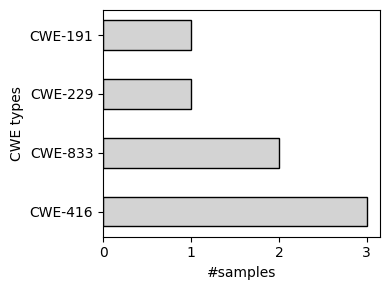

In [ ]:
# TODO: plot the value counts of the cwe types
cwe = df.x_redhatCweChain.str.split(':', expand=True)[0]
vals = cwe.value_counts()

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(vals.index, vals.values, color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('CWE types')
ax.set_xlabel('#samples')
plt.tight_layout()

plt.savefig(f'figure/CWE-types.png')
plt.show()

[17 15 11  8  5  5  4  4  3  3]


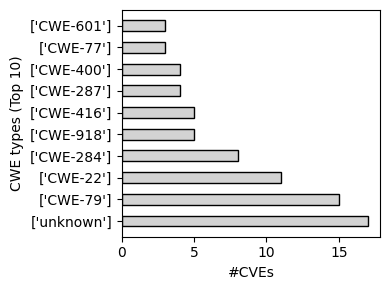

In [ ]:
vals = df['cwe'].value_counts().head(10)
x = [str(x) for x in vals.index]
print(vals.values)

fig, ax = plt.subplots(figsize=(4, 3))
bar_width = 0.5
bars = ax.barh(x, width=vals.values,color='lightgray', edgecolor='black', height=bar_width)
ax.set_ylabel('CWE types (Top 10)')
ax.set_xlabel('#CVEs')
plt.tight_layout()
plt.savefig(f'figure/CWE-types.png')
plt.show()

In [ ]:

def normalize_list_column(df, column):
    """Normalize a column containing lists
    put all the data into a single dataframe of all column value list
    """
    df_col = pd.DataFrame()
    for index, row in df.iterrows():
        if row[column]:
            df_part  = json_normalize(row[column])
            df_part['cveId'] = row['cveId']
            df_col = pd.concat([df_col, df_part], ignore_index=True)
    return df_col

# Check which columns contain lists
columns_with_lists = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]
print(f'Columns with list type: \n{columns_with_lists}\n')


# Normalize the columns with lists
# put all dataframes into a single dictionary
col_dfs = {}

for col in columns_with_lists:
    col_dfs[col] = normalize_list_column(df, column=col)
    # print(tabulate(df_part, headers='keys', tablefmt='psql'))
    print(f'Table: {col} - {col_dfs[col].shape}')
    # Save dataframes to csv files
    col_dfs[col].to_csv(output_dir + f'{col}.csv', index=False)

Columns with list type: 
['affected', 'credits', 'descriptions', 'impacts', 'metrics', 'problemTypes', 'references', 'timeline', 'workarounds', 'cwe']

Table: affected - (226, 9)
Table: credits - (8, 5)
Table: descriptions - (155, 4)
Table: impacts - (3, 3)
Table: metrics - (142, 31)
Table: problemTypes - (169, 2)
Table: references - (503, 4)
Table: timeline - (16, 4)
Table: workarounds - (8, 3)
Table: cwe - (173, 1)


# Parsing git patch from commit $hash.diff$

In [ ]:
def get_patch_from_url(url):
    """retrieve patch from the given git-based commit URL.
    """
    url_diff = url + '.diff'
    # diff = urllib.request.urlopen('https://github.com/ASSERT-KTH/RewardRepair/commit/2509b5e91e2e80b6b84da3d8cd0e1d1748c0ecfc.diff')
    diff = urllib.request.urlopen(url_diff)
    encoding = diff.headers.get_charsets()[0]
    patch = PatchSet(diff, encoding=encoding)
    return patch 

patch = get_patch_from_url('https://github.com/ASSERT-KTH/RewardRepair/commit/2509b5e91e2e80b6b84da3d8cd0e1d1748c0ecfc')
# patch = get_patch_from_url('https://github.com/PackageKit/PackageKit/commit/64278c9127e3333342b56ead99556161f7e86f79')

In [ ]:
import pandas as pd
from urllib.parse import urlparse

def parse_version_control_url(url):
    """Parse the version control URL
    """
    try:
        parsed_url = urlparse(url)
        # Combine the scheme and netloc to form the base URL
        base_url = parsed_url.scheme + "://" + parsed_url.netloc
        # Split the path by '/'
        path_components = parsed_url.path.split('/')
        # Extract the version control system and repository
        if "github.com" in parsed_url.netloc:
            vcs = "GitHub"
            repository = base_url + "/" + path_components[1] + "/" + path_components[2]
            commit_hash = path_components[4] if len(path_components) > 4 and path_components[3] == "commit" else None
        elif "gitlab.com" in parsed_url.netloc:
            vcs = "GitLab"
            repository = base_url + "/" + path_components[1] + "/" + path_components[2]
            commit_hash = path_components[5] if len(path_components) > 5 else None
        elif "bitbucket.org" in parsed_url.netloc:
            vcs = "Bitbucket"
            repository = base_url + "/" + path_components[1] + "/" + path_components[2]
            commit_hash = path_components[4] if len(path_components) > 4 and path_components[3] == "commits" else None
        else:
            vcs = None
            repository = None
            commit_hash = None
    except Exception as e:
        vcs = None
        repository = None
        commit_hash = None
    return vcs, repository, commit_hash


def parse_version_control_urls(urls):
    """Parse the version control URLs
    """
    vcss = []
    repositories = []
    commit_hashes = []
    # Iterate through URLs and parse them
    for url in urls:
        vcs, repository, commit_hash = parse_version_control_url(url)
        vcss.append(vcs)
        repositories.append(repository)
        commit_hashes.append(commit_hash)
    # Create a DataFrame
    data = {
        'url': urls,
        'vcs': vcss,
        'repository': repositories,
        'commit_hash': commit_hashes
    }
    return pd.DataFrame(data)

df_repo = parse_version_control_urls(urls)
df_repo.head()

# Save the DataFrame to sqlite3 database
df_repo.astype(str).to_sql('repository', conn, if_exists='replace', index=False)

503

In [ ]:
from tabulate import tabulate 
import itertools

def parse_before_after_code(hunk):
    """Parse the before and after code from a hunk
    """
    before_code = []
    after_code = []
    for line in hunk:
        if line.is_removed or line.is_context:
            # This line is part of the before code
            before_code.append(str(line)[1:])  # Exclude the '-' at the start
        if line.is_added or line.is_context:
            after_code.append(str(line)[1:])  # Exclude the '+' at the start

    # Join the lines of code into strings
    before_code = ''.join(before_code)
    after_code = ''.join(after_code)
    return before_code, after_code


def on_each_patch_file(patched_file):
    # Loop over each hunk in the patched file
    hunks = []
    for hunk in patched_file:
        # Parse the before and after code
        before_code, after_code = parse_before_after_code(hunk)
        hunk_data = {
            'file': patched_file.path, 
            'hunk': str(hunk),
            'hunk_patch': str(hunk), 
            'source': hunk.source,
            'target': hunk.target,
            'source_lines': hunk.source_lines,
            'target_lines': hunk.target_lines,
            'added_lines': [str(line)[1:] for line in hunk if line.is_added], 
            'removed_lines': [str(line)[1:] for line in hunk if line.is_removed], 
            'before_code': before_code,
            'after_code': after_code,
            'source_start': hunk.source_start,
            'source_length': hunk.source_length,
            'target_start': hunk.target_start,
            'target_length': hunk.target_length,
            'section_header': hunk.section_header,
            'hunk_length': len(hunk),
            }
        # Append the hunk data to the patch_hunks list
        hunks.append(hunk_data)
    return hunks

def parse_patchset(patch):
    """Parse the hunks from a patch
    """
    # Loop over each patched file in the diff
    patch_meta = {}
    patch_hunks = []

    for patched_file in patch:
        all_attrs = dir(patched_file)
        file_attrs = {}

        for attr in patched_file.__dict__:
            # Exclude attrs that start with '__' (dunder/magic methods)
            if not attr.startswith('__'):
                attr_value = getattr(patched_file, attr)
                file_attrs[attr] = attr_value
                
        patch_meta[patched_file.path] = file_attrs
        # Loop over each hunk in the patched file
        file_hunks = on_each_patch_file(patched_file)
        patch_hunks.extend(file_hunks)
    return patch_meta, patch_hunks

# Parse the patchset
patch_meta, patch_hunks = parse_patchset(patch)


df_hunk = pd.DataFrame(patch_hunks)
df_file = pd.DataFrame.from_dict(patch_meta, orient='index').reset_index()
df_file = df_file.rename(columns={'index': 'file'})

# Save the DataFrames to sqlite3 database
df_hunk.astype(str).to_sql('hunk', conn, if_exists='replace', index=False)
df_file.astype(str).to_sql('file', conn, if_exists='replace', index=False)

df_file.head()

,file,patch_info,source_file,source_timestamp,target_file,target_timestamp,is_binary_file
0,train.py,"[diff --git a/train.py b/train.py\n, index 5ad...",a/train.py,None,b/train.py,None,False


In [ ]:
df_repo_patch = pd.DataFrame()
df_repo_hunks = pd.DataFrame()

for url in df_repo.url.values:

    print(f'Processing URL: {url}')
    try:
        patch = get_patch_from_url(url)
        patch_meta, patch_hunks = parse_patchset(patch)

        df_hunk = pd.DataFrame(patch_hunks)

        df_file = pd.DataFrame.from_dict(patch_meta, orient='index').reset_index()
        df_file = df_file.rename(columns={'index': 'file'})
        df_file['url'] = url

        df_repo_patch = pd.concat([df_repo_patch, df_file], ignore_index=True)
        df_repo_hunks = pd.concat([df_repo_hunks, df_hunk], ignore_index=True)
    except Exception as exec:
        print(f'Error: {exec}')
        continue

Processing URL: https://github.com/chromiumembedded/cef/security/advisories/GHSA-3h3j-38xq-v7hh
Error: HTTP Error 406: Not Acceptable
Processing URL: https://github.com/chromiumembedded/cef/commit/1f55d2e12f62cfdfbf9da6968fde2f928982670b
Processing URL: https://github.com/flarum/framework/security/advisories/GHSA-733r-8xcp-w9mr
Error: HTTP Error 406: Not Acceptable
Processing URL: https://github.com/flarum/flarum-core/commit/ee8b3b4ad1413a2b0971fdd9e40f812d2a3a9d3a
Processing URL: https://github.com/flarum/framework/commit/7d70328471cf3091d92d95c382d277aec7996176
Processing URL: https://github.com/peteroupc/CBOR/security/advisories/GHSA-6r92-cgxc-r5fg
Error: HTTP Error 406: Not Acceptable
Processing URL: https://github.com/peteroupc/CBOR/commit/b4117dbbb4cd5a4a963f9d0c9aa132f033e15b95
Processing URL: https://github.com/peteroupc/CBOR/compare/v4.5...v4.5.1
Processing URL: https://github.com/advisories/GHSA-6r92-cgxc-r5fg
Error: HTTP Error 406: Not Acceptable
Processing URL: https://vuln

In [ ]:
# Save the DataFrames to sqlite3 database
df_repo_patch.astype(str).to_sql('patch_collection', conn, if_exists='replace', index=False)
df_repo_hunks.astype(str).to_sql('hunk_collection', conn, if_exists='replace', index=False)

5231

In [ ]:
# # parse all the patches from the patch links
# def parse_all_patches(patch_links):
#     """Parse all the patches from the patch links
#     """
#     all_patches = {}
#     for json_file, commit_urls in patch_links.items():
#         print(f'Parsing patches for {json_file}')
#         for url in commit_urls:
#             try:
#                 patch = get_patch_from_url(url)
#                 patch_meta, patch_hunks = parse_patch_hunks(patch)
#                 all_patches[url] = (patch_meta, patch_hunks)
#             except Exception as e:
#                 print(f'Error parsing patch: {e}')
#     return all_patches

In [ ]:
import uuid 
  
id = uuid.uuid4().hex
id

In [ ]:
def get_language_from_ext(file_path):
    extension = file_path.split('.')[-1].lower()
    language_mapping = {
        'c': 'C',
        'h': 'C',
        'cpp': 'C++',
        'hpp': 'C++',
        'java': 'Java',
        'py': 'Python',
        'js': 'JavaScript',
        'html': 'HTML',   # Markup language, not a programming language
        'htm': 'HTML',
        'css': 'CSS',     # Style sheet language, not a programming language
        'php': 'PHP',
        'rb': 'Ruby',
        'swift': 'Swift',
        'cs': 'C#',
        'vb': 'Visual Basic',
        'go': 'Go',
        'rust': 'Rust',
        'ts': 'TypeScript',
        'dart': 'Dart',
        'pl': 'Perl',
        'lua': 'Lua',
        'sh': 'Shell script',
        'ps1': 'PowerShell script',
        'jsx': 'JSX',     # JavaScript extension used with React
        'tsx': 'TypeScript with JSX',  # Used with React
        'r': 'R',
        'scala': 'Scala',
        'jl': 'Julia',
        'matlab': 'MATLAB',
        'asm': 'Assembly',
        'sql': 'SQL',     # Query language, not a programming language
        'kt': 'Kotlin',
        'vue': 'Vuejs',  # JavaScript framework
        'scss': 'SASS',   # CSS preprocessor
        'sass': 'SASS'
    }
    return language_mapping.get(extension, 'Unknown')

def parse_patch(patch):
    """parse patch and convert it into dataframe
    """
    # Access information about each file in the patchset
    data = {'file': [], 'removed': [], 'added': [], 'unchanged':[], 'pl':[]}

    for patched_file in patch:
        for hunk in patched_file:
            added_lines = [line.value.strip() for line in hunk if line.is_added]
            removed_lines = [line.value.strip() for line in hunk if line.is_removed]
            unchanged_lines = [line.value.strip() for line in hunk if not line.is_added and not line.is_removed]
            
            data['file'].append(patched_file.path)
            data['added'].append('\n'.join(added_lines))
            data['removed'].append('\n'.join(removed_lines))
            data['unchanged'].append('\n'.join(unchanged_lines))
            data['pl'].append(get_language_from_ext(patched_file.path))
    return data


def collect_patches(github_urls):
    """collect patches of the given URLs
    """
    df  = pd.DataFrame()
    for url in github_urls:
        try:
            patch = get_patch_from_url(url)
            data = parse_patch(patch)
            df_patch = pd.DataFrame(data)
            df_patch['url'] = url 
            df = pd.concat([df, df_patch]) if len(data) > 0 else df
        except Exception as exec:
            print(f'Error processing {url}: \n{exec}')
    return df.reset_index(drop=True)

# url = 'https://github.com/torvalds/linux/commit/3f24fcdacd40c70dd2949c1cfd8cc2e75942a9e3'
# patch = get_patch_from_url(url)

urls = list(col_dfs['references'].url)

github_urls = [url for url in urls if 'commit' in url]
df_patch = collect_patches(github_urls)

In [ ]:
df_patch.to_csv(f'{output_dir}/patches.csv', index=False)

# Save the DataFrame to sqlite3 database
df_patch.astype(str).to_sql('patch', conn, if_exists='replace', index=False)